# LinkedIn Job Postings — End‑to‑End Analytics Project

**Author:** Mahammad Rafik Bellamkonda  
**Last Updated:** 2025-08-28

This notebook presents an end‑to‑end analysis of LinkedIn job postings to uncover hiring trends, skills in demand, salary distributions, and location‑wise opportunities.

## Objectives
- Build a reproducible analytics workflow (ingest → preprocess → analyze → visualize).
- Quantify demand by company, role/title, location, and industry.
- Explore salary levels and distributions.
- Extract and rank skills in demand from job descriptions.
- Provide interactive filtering to explore data by role, location, experience, and industry.
- Summarize actionable insights for job seekers and recruiters.

## Dataset
This project uses a **LinkedIn job postings** dataset hosted on Kaggle. The dataset typically contains fields such as:
- `job_id`, `job_title`, `company`, `location`, `post_date`, `employment_type`
- `experience_level`, `industry`, `job_description`, `skills`
- `salary` or `salary_range`.

> 🔎 **Note**: Column names vary by dataset version. The code is written to be **defensive** and will adapt when columns are missing or named slightly differently.



## Reproducibility & Environment

- Language: Python 3.10+  
- Core libraries: `pandas`, `numpy`, `matplotlib`, `seaborn`,`kagglehub`  

>If running locally, ensure the libraries are available in your environment. If a library is missing, install it via pip.

# 1. Setup & Imports
Import core libraries used for data handling, visualization.

In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from functools import reduce 
from wordcloud import WordCloud

# 2. Data Ingestion & Load Data

Download the dataset with `kagglehub`.  
Provide the **filename** inside the downloaded directory.
 
> Example filename: `postings.csv`

Read the dataset into a pandas DataFrame and take a first look at the schema and sample rows.
> NOTE: Download **"Postings"** dataset from : https://www.kaggle.com/datasets/arshkon/linkedin-job-postings

In [8]:
# main dataframe
job_postings_data = pd.read_csv("postings.csv")
job_postings_data

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123844,3906267117,Lozano Smith,Title IX/Investigations Attorney,Our Walnut Creek office is currently seeking a...,195000.0,YEARLY,"Walnut Creek, CA",56120.0,1.0,NaN,...,NaN,1.713571e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,94595.0,6013.0
123845,3906267126,Pinterest,"Staff Software Engineer, ML Serving Platform",About Pinterest:\n\nMillions of people across ...,NaN,NaN,United States,1124131.0,3.0,NaN,...,NaN,1.713572e+12,www.pinterestcareers.com,0,FULL_TIME,NaN,NaN,NaN,NaN,NaN
123846,3906267131,EPS Learning,"Account Executive, Oregon/Washington",Company Overview\n\nEPS Learning is a leading ...,NaN,NaN,"Spokane, WA",90552133.0,3.0,NaN,...,NaN,1.713572e+12,epsoperations.bamboohr.com,0,FULL_TIME,NaN,NaN,NaN,99201.0,53063.0
123847,3906267195,Trelleborg Applied Technologies,Business Development Manager,The Business Development Manager is a 'hunter'...,NaN,NaN,"Texas, United States",2793699.0,4.0,NaN,...,NaN,1.713573e+12,NaN,0,FULL_TIME,NaN,NaN,NaN,NaN,NaN


# 3. Data Preprocessing

Steps performed:  

1. **Drop duplicates** and handle missing values minimally.  
2. **Merge all other dataframes into the main dataframe** using **job_id**:  
   - job_postings_data  
   - job_benefits_data  
   - job_skills_data  
   - company_industries_data  
   - company_specialities_data  
   - employee_counts_data  
3. **Eliminate unnecessary columns** and rename columns for better understanding.  


Let's check if there is duplicate and null in job_id

In [9]:
duplicates = job_postings_data['job_id'].duplicated()
num_duplicates = duplicates.sum()
num_duplicates

0

In [10]:
job_postings_data['job_id'].isnull().sum()

0

There is no duplicate and no null so move on to the next step.

In benefits.csv there exist duplicate job_id and unrelated inferred column so lets combine the duplicate job_id and remove the inferred column

In [12]:
job_benefits_data = pd.read_csv("benefits.csv")
job_benefits_data = job_benefits_data.drop('inferred', axis=1) # remove 'inferred' column
job_benefits_data = job_benefits_data.groupby('job_id')['type'].agg(lambda x: ', '.join(x)).reset_index() # aggregate same job benefits

Then we merge our main dataframe with job benefits dataframe

In [13]:
job_postings_data = job_postings_data.merge(job_benefits_data, on="job_id", how="left")
job_postings_data

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips,type
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0,NaN
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0,NaN
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0,NaN
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0,401(k)
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123844,3906267117,Lozano Smith,Title IX/Investigations Attorney,Our Walnut Creek office is currently seeking a...,195000.0,YEARLY,"Walnut Creek, CA",56120.0,1.0,NaN,...,1.713571e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,94595.0,6013.0,"Medical insurance, Vision insurance, Dental in..."
123845,3906267126,Pinterest,"Staff Software Engineer, ML Serving Platform",About Pinterest:\n\nMillions of people across ...,NaN,NaN,United States,1124131.0,3.0,NaN,...,1.713572e+12,www.pinterestcareers.com,0,FULL_TIME,NaN,NaN,NaN,NaN,NaN,NaN
123846,3906267131,EPS Learning,"Account Executive, Oregon/Washington",Company Overview\n\nEPS Learning is a leading ...,NaN,NaN,"Spokane, WA",90552133.0,3.0,NaN,...,1.713572e+12,epsoperations.bamboohr.com,0,FULL_TIME,NaN,NaN,NaN,99201.0,53063.0,NaN
123847,3906267195,Trelleborg Applied Technologies,Business Development Manager,The Business Development Manager is a 'hunter'...,NaN,NaN,"Texas, United States",2793699.0,4.0,NaN,...,1.713573e+12,NaN,0,FULL_TIME,NaN,NaN,NaN,NaN,NaN,NaN


We will also merge duplicate job_id on job_skills.csv and join them into the main dataframe

In [50]:
job_skills_data = pd.read_csv("job_skills.csv")
job_skills_data = job_skills_data.groupby('job_id')['skill_abr'].agg(lambda x: ', '.join(x)).reset_index() # aggregate same job skills

job_postings_data = job_postings_data.merge(job_skills_data, on="job_id", how="left")
job_postings_data

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips,type,skill_abr
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0,NaN,"MRKT, SALE"
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0,NaN,HCPR
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0,NaN,"MGMT, MNFC"
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0,401(k),OTHR
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0,NaN,IT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123844,3906267117,Lozano Smith,Title IX/Investigations Attorney,Our Walnut Creek office is currently seeking a...,195000.0,YEARLY,"Walnut Creek, CA",56120.0,1.0,NaN,...,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,94595.0,6013.0,"Medical insurance, Vision insurance, Dental in...","LGL, BD"
123845,3906267126,Pinterest,"Staff Software Engineer, ML Serving Platform",About Pinterest:\n\nMillions of people across ...,NaN,NaN,United States,1124131.0,3.0,NaN,...,www.pinterestcareers.com,0,FULL_TIME,NaN,NaN,NaN,NaN,NaN,NaN,"ENG, IT"
123846,3906267131,EPS Learning,"Account Executive, Oregon/Washington",Company Overview\n\nEPS Learning is a leading ...,NaN,NaN,"Spokane, WA",90552133.0,3.0,NaN,...,epsoperations.bamboohr.com,0,FULL_TIME,NaN,NaN,NaN,99201.0,53063.0,NaN,"SALE, BD"
123847,3906267195,Trelleborg Applied Technologies,Business Development Manager,The Business Development Manager is a 'hunter'...,NaN,NaN,"Texas, United States",2793699.0,4.0,NaN,...,NaN,0,FULL_TIME,NaN,NaN,NaN,NaN,NaN,NaN,"BD, SALE"


The job_details data is done, next we will pre-process the company_details data

In [14]:
company_data = pd.read_csv("companies.csv")

company_industries_data = pd.read_csv("company_industries.csv")
company_industries_data = company_industries_data.groupby('company_id')['industry'].agg(lambda x: ', '.join(x)).reset_index() # aggregate same company industries

company_specialities_data = pd.read_csv("company_specialities.csv")
company_specialities_data = company_specialities_data.groupby('company_id')['speciality'].agg(lambda x: ', '.join(x)).reset_index() # aggregate same company specialities

employee_counts_data = pd.read_csv("employee_counts.csv")
employee_counts_data = employee_counts_data.groupby('company_id')['time_recorded'].max().reset_index() # get newest data based on 'time_recorded' column

company_data = company_data.merge(company_industries_data, on="company_id", how="left")
company_data = company_data.merge(company_specialities_data, on="company_id", how="left")
company_data = company_data.merge(employee_counts_data, on="company_id", how="left")
company_data

,company_id,name,description,company_size,state,country,city,zip_code,address,url,industry,speciality,time_recorded
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm,IT Services and IT Consulting,"Cloud, Mobile, Cognitive, Security, Research, ...",1713501255
1,1016,GE HealthCare,Every day millions of people feel the impact o...,7.0,0,US,Chicago,0,-,https://www.linkedin.com/company/gehealthcare,Hospitals and Health Care,"Healthcare, Biotechnology",1713569031
2,1025,Hewlett Packard Enterprise,Official LinkedIn of Hewlett Packard Enterpris...,7.0,Texas,US,Houston,77389,1701 E Mossy Oaks Rd Spring,https://www.linkedin.com/company/hewlett-packa...,IT Services and IT Consulting,NaN,1713453258
3,1028,Oracle,We’re a cloud technology company that provides...,7.0,Texas,US,Austin,78741,2300 Oracle Way,https://www.linkedin.com/company/oracle,IT Services and IT Consulting,"enterprise, software, applications, database, ...",1713540073
4,1033,Accenture,Accenture is a leading global professional ser...,7.0,0,IE,Dublin 2,0,Grand Canal Harbour,https://www.linkedin.com/company/accenture,Business Consulting and Services,"Management Consulting, Systems Integration and...",1713569451
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24468,103463217,JRC Services,NaN,2.0,0,0,0,0,0,https://www.linkedin.com/company/jrcservices,Facilities Services,NaN,1713552037
24469,103466352,Centent Consulting LLC,Centent Consulting LLC is a reputable human re...,NaN,0,0,0,0,0,https://www.linkedin.com/company/centent-consu...,Business Consulting and Services,NaN,1713550651
24470,103467540,"Kings and Queens Productions, LLC",We are a small but mighty collection of thinke...,NaN,0,0,0,0,0,https://www.linkedin.com/company/kings-and-que...,Broadcast Media Production and Distribution,NaN,1713554225
24471,103468936,WebUnite,Our mission at WebUnite is to offer experience...,NaN,Pennsylvania,US,Southampton,18966,720 2nd Street Pike,https://www.linkedin.com/company/webunite,Business Consulting and Services,NaN,1713535939


Finally we merge job postings and company data together and we have data about company that post jobs on linkedIn.

In [15]:
merged_data = job_postings_data.merge(company_data, on="company_id", how="left")
merged_data

,job_id,company_name,title,description_x,max_salary,pay_period,location,company_id,views,med_salary,...,company_size,state,country,city,zip_code_y,address,url,industry,speciality,time_recorded
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,2.0,NJ,US,Jersey City,07302,242 Tenth Street,https://www.linkedin.com/company/corcoran-sawy...,Real Estate,"real estate, new development",1.713409e+09
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,1.0,Ohio,US,Mariemont,45227,6880 Wooster Pike,https://www.linkedin.com/company/the-national-...,Restaurants,NaN,1.713279e+09
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,2.0,New York,US,Lake Success,11042,3 Dakota Drive,https://www.linkedin.com/company/abrams-fenste...,Law Practice,"Civil Litigation, Corporate & Securities Law, ...",1.712897e+09
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123844,3906267117,Lozano Smith,Title IX/Investigations Attorney,Our Walnut Creek office is currently seeking a...,195000.0,YEARLY,"Walnut Creek, CA",56120.0,1.0,NaN,...,2.0,California,US,Fresno,93720,7404 N Spalding Ave,https://www.linkedin.com/company/lozano-smith,Law Practice,"Education Law, Public Agency Law, Special Educ...",1.713570e+09
123845,3906267126,Pinterest,"Staff Software Engineer, ML Serving Platform",About Pinterest:\n\nMillions of people across ...,NaN,NaN,United States,1124131.0,3.0,NaN,...,5.0,California,US,San Francisco,0,505 Brannan St,https://www.linkedin.com/company/pinterest,Software Development,NaN,1.713572e+09
123846,3906267131,EPS Learning,"Account Executive, Oregon/Washington",Company Overview\n\nEPS Learning is a leading ...,NaN,NaN,"Spokane, WA",90552133.0,3.0,NaN,...,2.0,MD,US,Bethesda,20814,4800 Hampden Ln,https://www.linkedin.com/company/epslearning,Education Administration Programs,NaN,1.713572e+09
123847,3906267195,Trelleborg Applied Technologies,Business Development Manager,The Business Development Manager is a 'hunter'...,NaN,NaN,"Texas, United States",2793699.0,4.0,NaN,...,2.0,Lancashire,GB,Rochdale,OL11 1TQ,Eagle Way,https://www.linkedin.com/company/trelleborg-ap...,Industrial Machinery Manufacturing,"Energy Control Materials, Embedded Rail System...",1.713573e+09


In [26]:
merged_data.isnull().sum()

job_id                             0
company_name                    1719
title                              0
description_x                      7
max_salary                     94056
pay_period                     87776
location                           0
company_id                      1717
views                           1689
med_salary                    117569
min_salary                     94056
formatted_work_type                0
applies                       100529
original_listed_time               0
remote_allowed                108603
job_posting_url                    0
application_url                36665
application_type                   0
expiry                             0
closed_time                   122776
formatted_experience_level     29409
skills_desc                   121410
listed_time                        0
posting_domain                 39968
sponsored                          0
work_type                          0
currency                       87776
c

Next we will eliminate certain column to use for analysis, and then rename the column for better understanding

In [16]:
choosen_column = ['title','name','description_x','formatted_work_type','location','original_listed_time','application_type','sponsored','description_y','company_size','industry']
merged_data = merged_data[choosen_column]
merged_data

,title,name,description_x,formatted_work_type,location,original_listed_time,application_type,sponsored,description_y,company_size,industry
0,Marketing Coordinator,Corcoran Sawyer Smith,Job descriptionA leading real estate firm in N...,Full-time,"Princeton, NJ",1.713398e+12,ComplexOnsiteApply,0,With years of experience helping local buyers ...,2.0,Real Estate
1,Mental Health Therapist/Counselor,NaN,"At Aspen Therapy and Wellness , we are committ...",Full-time,"Fort Collins, CO",1.712858e+12,ComplexOnsiteApply,0,NaN,NaN,NaN
2,Assitant Restaurant Manager,The National Exemplar,The National Exemplar is accepting application...,Full-time,"Cincinnati, OH",1.713278e+12,ComplexOnsiteApply,0,"In April of 1983, The National Exemplar began ...",1.0,Restaurants
3,Senior Elder Law / Trusts and Estates Associat...,"Abrams Fensterman, LLP",Senior Associate Attorney - Elder Law / Trusts...,Full-time,"New Hyde Park, NY",1.712896e+12,ComplexOnsiteApply,0,"Abrams Fensterman, LLP is a full-service law f...",2.0,Law Practice
4,Service Technician,NaN,Looking for HVAC service tech with experience ...,Full-time,"Burlington, IA",1.713452e+12,ComplexOnsiteApply,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
123844,Title IX/Investigations Attorney,Lozano Smith,Our Walnut Creek office is currently seeking a...,Full-time,"Walnut Creek, CA",1.713571e+12,ComplexOnsiteApply,0,"For more than 30 years, Lozano Smith has serve...",2.0,Law Practice
123845,"Staff Software Engineer, ML Serving Platform",Pinterest,About Pinterest:\n\nMillions of people across ...,Full-time,United States,1.713572e+12,OffsiteApply,0,Pinterest's mission is to bring everyone the i...,5.0,Software Development
123846,"Account Executive, Oregon/Washington",EPS Learning,Company Overview\n\nEPS Learning is a leading ...,Full-time,"Spokane, WA",1.713572e+12,OffsiteApply,0,EPS Learning has partnered with educators for ...,2.0,Education Administration Programs
123847,Business Development Manager,Trelleborg Applied Technologies,The Business Development Manager is a 'hunter'...,Full-time,"Texas, United States",1.713573e+12,ComplexOnsiteApply,0,Trelleborg Applied Technologies manufactures a...,2.0,Industrial Machinery Manufacturing


In [17]:
pretty_column_name = {'title': 'job_title', 'name': 'company_name', 'description_x': 'job_description',
               'formatted_work_type': 'work_type','original_listed_time': 'listed_time','description_y': 'company_description'}
data = merged_data.rename(columns=pretty_column_name)
data = data.dropna()
data

,job_title,company_name,job_description,work_type,location,listed_time,application_type,sponsored,company_description,company_size,industry
0,Marketing Coordinator,Corcoran Sawyer Smith,Job descriptionA leading real estate firm in N...,Full-time,"Princeton, NJ",1.713398e+12,ComplexOnsiteApply,0,With years of experience helping local buyers ...,2.0,Real Estate
2,Assitant Restaurant Manager,The National Exemplar,The National Exemplar is accepting application...,Full-time,"Cincinnati, OH",1.713278e+12,ComplexOnsiteApply,0,"In April of 1983, The National Exemplar began ...",1.0,Restaurants
3,Senior Elder Law / Trusts and Estates Associat...,"Abrams Fensterman, LLP",Senior Associate Attorney - Elder Law / Trusts...,Full-time,"New Hyde Park, NY",1.712896e+12,ComplexOnsiteApply,0,"Abrams Fensterman, LLP is a full-service law f...",2.0,Law Practice
5,Economic Development and Planning Intern,Downtown Raleigh Alliance,Job summary:The Economic Development & Plannin...,Internship,"Raleigh, NC",1.713456e+12,ComplexOnsiteApply,0,Mission of the Downtown Raleigh Alliance (DRA)...,1.0,Non-profit Organizations
8,Respiratory Therapist,Children's Nebraska,"At Children’s, the region’s only full-service ...",Full-time,"Omaha, NE",1.712348e+12,OffsiteApply,0,"At Children’s Nebraska, our mission is to impr...",5.0,Hospitals and Health Care
...,...,...,...,...,...,...,...,...,...,...,...
123844,Title IX/Investigations Attorney,Lozano Smith,Our Walnut Creek office is currently seeking a...,Full-time,"Walnut Creek, CA",1.713571e+12,ComplexOnsiteApply,0,"For more than 30 years, Lozano Smith has serve...",2.0,Law Practice
123845,"Staff Software Engineer, ML Serving Platform",Pinterest,About Pinterest:\n\nMillions of people across ...,Full-time,United States,1.713572e+12,OffsiteApply,0,Pinterest's mission is to bring everyone the i...,5.0,Software Development
123846,"Account Executive, Oregon/Washington",EPS Learning,Company Overview\n\nEPS Learning is a leading ...,Full-time,"Spokane, WA",1.713572e+12,OffsiteApply,0,EPS Learning has partnered with educators for ...,2.0,Education Administration Programs
123847,Business Development Manager,Trelleborg Applied Technologies,The Business Development Manager is a 'hunter'...,Full-time,"Texas, United States",1.713573e+12,ComplexOnsiteApply,0,Trelleborg Applied Technologies manufactures a...,2.0,Industrial Machinery Manufacturing




## 4. Exploratory Data Analysis (EDA)

Key questions explored:
- Which **companies** and **Job types** post the most jobs?
- What **roles/titles** are most common?
- What do **salary distributions** look like ?
- Which **skills** are most in demand?


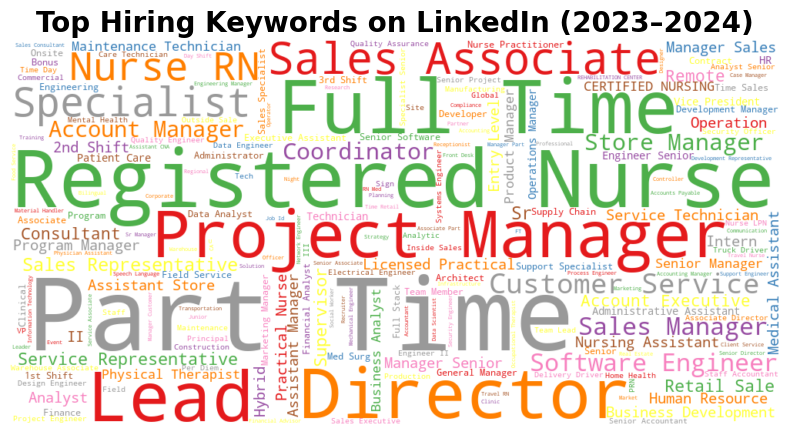

In [18]:
# Visualization 1: Top Hiring Keywords on Linkedin 2023-24 (WordCloud)
# Create a word cloud from job titles
job_titles_text = ' '.join(data['job_title']) 
wordcloud = WordCloud(width=1000, height=500, background_color='white',colormap='Set1').generate(job_titles_text)

# Display the word cloud
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top Hiring Keywords on LinkedIn (2023–2024)', fontsize=20,fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

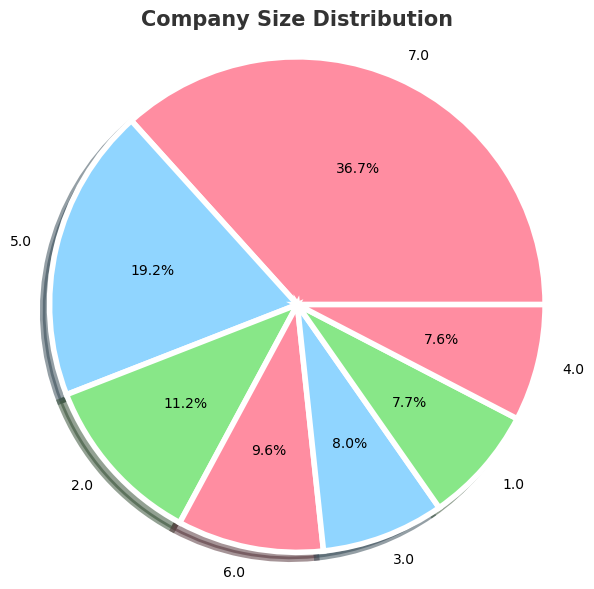

In [56]:
# Visualization 2: Company Size Distribution (Pie Chart)
company_size_counts = data['company_size'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(company_size_counts, wedgeprops={"linewidth": 4, "edgecolor": "white"} , labels=company_size_counts.index, autopct='%1.1f%%',colors=['#FF8DA1', '#90D5FF', '#88E788',],shadow=True)
plt.axis('equal')
plt.title('Company Size Distribution',color="#333333",fontsize=15,fontweight='bold')
plt.tight_layout()
plt.show()

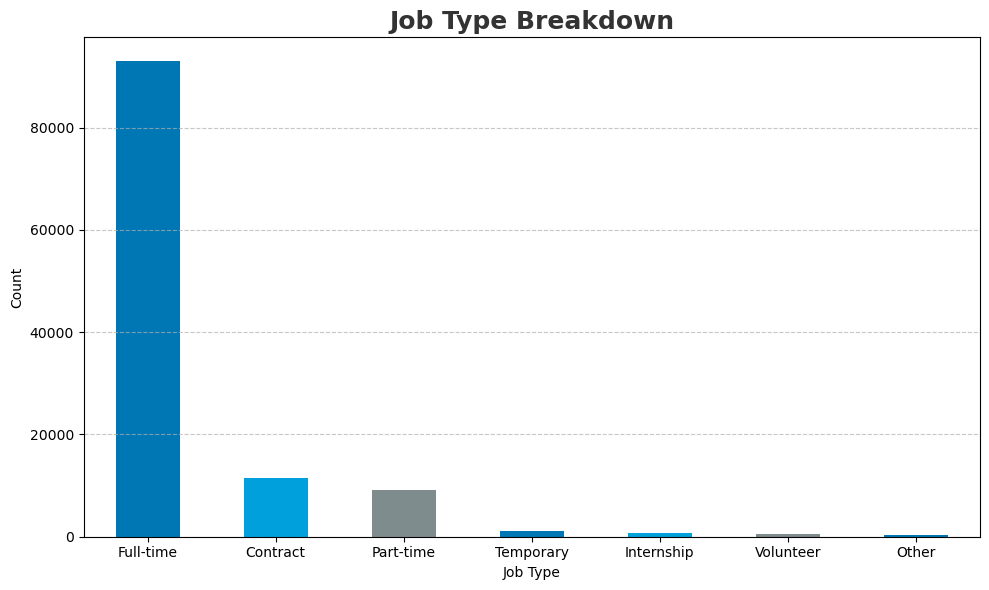

In [60]:
# Visualization 3: Job Type Breakdown (Bar Chart)
job_type_counts = data['work_type'].value_counts()
plt.figure(figsize=(10, 6))
job_type_counts.plot(kind='bar', color=['#0077B5', '#00A0DC', '#7F8C8D'])
plt.title('Job Type Breakdown', fontsize=18, fontweight='bold', color="#333333")
plt.xlabel('Job Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


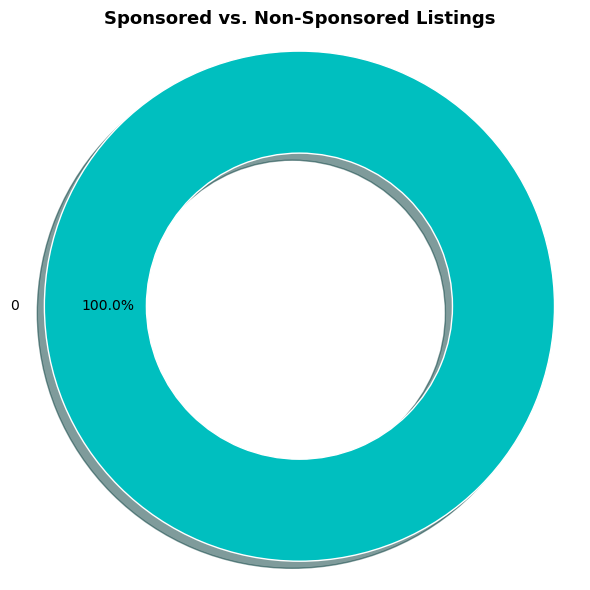

In [19]:
# Visualization 4: Sponsored vs. Non-Sponsored Listings (Pie Chart)
sponsored_counts = data['sponsored'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sponsored_counts, labels=sponsored_counts.index.astype(str),autopct='%1.1f%%',pctdistance=0.75, colors='coral',shadow=True,wedgeprops={'width':0.4, 'edgecolor':'white'} )
plt.title('Sponsored vs. Non-Sponsored Listings', fontsize=13, fontweight='bold',loc='center')
plt.axis('equal')
plt.tight_layout()
plt.show()


## 5. Insights & Findings

This section summarizes key takeaways from the analysis. Rerun after exploring the EDA cells.

- **Hiring Hotspots:** Locations with the highest number of postings indicate where hiring is most active.
- **Role Demand:** Frequently appearing job titles reveal top roles (e.g., Data Analyst, Data Engineer).  
- **Top Recruiters**: Companies with the highest number of job postings represent the top recruiters.

In [62]:

summary = {}

if "company_name" in data.columns:
    summary["top_companies"] = data["company_name"].value_counts().head(10).index.tolist()
if "location" in data.columns:
    summary["top_locations"] = data["location"].value_counts().head(10).index.tolist()
if "job_title" in data.columns:
    summary["top_titles"] = data["job_title"].value_counts().head(10).index.tolist()
summary

{'top_companies': ['Liberty Healthcare and Rehabilitation Services',
  'The Job Network',
  'J. Galt',
  'TEKsystems',
  "Lowe's Companies, Inc.",
  'Ingersoll Rand',
  'Capital One',
  'Cogent Communications',
  'Insight Global',
  'Dice'],
 'top_locations': ['United States',
  'New York, NY',
  'Chicago, IL',
  'Houston, TX',
  'Dallas, TX',
  'Atlanta, GA',
  'Boston, MA',
  'Austin, TX',
  'Charlotte, NC',
  'Phoenix, AZ'],
 'top_titles': ['Sales Manager',
  'Customer Service Representative',
  'Project Manager',
  'Senior Accountant',
  'Registered Nurse',
  'Executive Assistant',
  'Administrative Assistant',
  'Receptionist',
  'Retail Sales Associate',
  'Sales Associate']}

## 6. Conclusion

 - The LinkedIn job postings dataset reveals valuable insights into the current job market. This analysis can help job seekers understand demand, and recruiters track hiring trends.


   **Future Scope**
- Add **NLP** to classify roles (e.g., Data vs. Software vs. Product).
- Build a **salary prediction model** (if targets present) using regression.
- Publish a **live dashboard** in Power BI or Plotly Dash / Streamlit.
- Automate **fresh data ingestion** (scheduled pulls) and trend alerts

